# Analysis of cell count per organoid
*Author: Felix Romer*<br/>
*Data: 27/02/2024*<br/>
<br/>
The underlying data is spinning disc microscopy data of organoids, stained with DAPI. Because of technical problems (strong bleaching for nuclei in lower half of organoids) only the top half of the organoids were counted. The radius in z as well as the diameter in x and y direction where measured. With that the surface of the ellipsoid describing the organoid will be calculated.<br/>
For some organoid the attempt was made to calculate all cells. This was often not too successful.

## 1. Set up
Imports, data loading, global variables  

In [39]:
# Import needed packages
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy.special import ellipkinc, ellipeinc
from functions import ellipsoid_surface_area, calculate_difference
from matplotlib.legend_handler import HandlerTuple

#statistic
from statannot import add_stat_annotation
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load data
file_loc = 'Confocal image metrics data.xlsx'
Data = pd.read_excel(file_loc)

# global variables
CF_xy = 1       # is already in µm
CF_z  = 2.25

## 2. Process data
* extract experiment conditions
* calculate ellipsoid surface area
* calculate other features of interest

In [48]:
# Define a regular expression to extract one and two-digit numbers within text
# First number corresponds to the biological replication (different animal)
# Second number corresponds to the technical replication (different slide)
# Third number corresponds to the organoid number
pattern = r'(?<!\d)(\d{1,2})(?!\d)'

# Extract meta data from Name column
Data['Replication']             = Data['Name'].str.findall(pattern).str[0].astype(int)
Data['Slide_number']            = Data['Name'].str.findall(pattern).str[1].astype(int)
Data['Organoid_number']         = Data['Name'].str.findall(pattern).str[2].astype(int)
Data['Category']                = Data['Name'].apply(lambda x: 'Control' if 'Control' in x else 'H. pylori')
Data['Infection_time']          = Data['Name'].apply(lambda x: 'Early life' if 'Early life' in x else 'Late life')
Data['Condition']               = Data['Infection_time'] + " " + Data['Category']

# Scale data
Data['number slices top half']  = Data['number slices top half'].apply(calculate_difference)
Data['dz']                      = Data['number slices top half'] * CF_z

# Calculate surface of ellipsoid
Data['Ellipsoid_surface_area']  = Data.apply(lambda row: ellipsoid_surface_area(row['dz'], row['small diameter µm'], row['biggest diameter µm']), axis=1)
Data['cells_per_area']          = Data['number cells top half'] / Data['Ellipsoid_surface_area'] * 2000000000
Data['cells_per_area_log']      = np.log(Data['cells_per_area'])

# Remove untrusted datapoints
DataTrusted = Data[Data['Data trustable'] == "Yes"]

DataTrusted.head(5)

,Name,Experiment,Group,number slices top half,small diameter µm,biggest diameter µm,number cells top half,note for top half,Data trustable,number cells,...,Replication,Slide_number,Organoid_number,Category,Infection_time,Condition,dz,Ellipsoid_surface_area,cells_per_area,cells_per_area_log
0,Early life 1Control1 Ctrl 1,EL1,Control,58.0,396.0,408.0,756.0,good signal,Yes,1254,...,1,1,1,Control,Early life,Early life Control,130.50,1.217802e+06,1.241581e+06,14.031896
1,Early life 1Control1 Ctrl 2,EL1,Control,73.0,450.0,505.0,1212.0,good signal,Yes,1317,...,1,1,2,Control,Early life,Early life Control,164.25,1.741135e+06,1.392195e+06,14.146392
2,Early life 1Control1 Ctrl 3,EL1,Control,38.0,249.0,264.0,193.0,good signal,Yes,254,...,1,1,3,Control,Early life,Early life Control,85.50,4.989870e+05,7.735673e+05,13.558768
3,Early life 1Control1 Ctrl 4,EL1,Control,46.0,260.0,308.0,235.0,"top folded, but looks good",Yes,328,...,1,1,4,Control,Early life,Early life Control,103.50,6.245816e+05,7.525038e+05,13.531161
4,Early life 1Control1 Ctrl 5,EL1,Control,77.0,442.0,518.0,970.0,signal get a little bad at bottom but looks good,Yes,979,...,1,1,5,Control,Early life,Early life Control,173.25,1.780110e+06,1.089820e+06,13.901523


## 3. Statistical analysis

- Celldensity not normla distributet -> transform with to log space

#### 3.1 H0: Cell density increases with infection

In [65]:
model = ols('cells_per_area_log ~ C(Condition)', data=DataTrusted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
# perform post-hoc testing with Tukey's HSD test
posthoc = pairwise_tukeyhsd(DataTrusted['cells_per_area_log'], DataTrusted['Condition'])

# print the ANOVA table and post-hoc results
print(anova_table)
print('---------')
print(posthoc)

                 sum_sq     df         F    PR(>F)
C(Condition)   0.122183    2.0  0.311895  0.732541
Residual      28.793192  147.0       NaN       NaN
---------
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1               group2        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------
  Early life Control Early life H. pylori   0.0613  0.723 -0.1277 0.2503  False
  Early life Control    Late life Control   0.0125  0.997 -0.3896 0.4145  False
Early life H. pylori    Late life Control  -0.0489 0.9516 -0.4343 0.3366  False
-------------------------------------------------------------------------------


- No significant differences between the groups. 
- H. pylori infection leads to small increase in cell density in early life
- From early to late life cell density stays more or less stabel

#### 3.2 H0: Cell density decreses when mouse is older

- See above. No significant difference

#### 3.3 H0: Correlation between celldensity and organoid size differes between conditions

In [82]:
# Assuming you have a DataFrame named 'data' with columns 'dependent_variable', 'covariate', and 'group'
formula = 'Ellipsoid_surface_area ~ cells_per_area_log + C(Condition)'
model = ols(formula, DataTrusted).fit()
print(model.summary())

# Print the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform post-hoc testing (Tukey's HSD) if needed
from statsmodels.stats.multicomp import pairwise_tukeyhsd

posthoc = pairwise_tukeyhsd(DataTrusted['Ellipsoid_surface_area'], DataTrusted['Condition'])
print(posthoc)

                              OLS Regression Results                              
Dep. Variable:     Ellipsoid_surface_area   R-squared:                       0.311
Model:                                OLS   Adj. R-squared:                  0.297
Method:                     Least Squares   F-statistic:                     21.97
Date:                    Fri, 08 Mar 2024   Prob (F-statistic):           8.49e-12
Time:                            16:36:32   Log-Likelihood:                -2269.0
No. Observations:                     150   AIC:                             4546.
Df Residuals:                         146   BIC:                             4558.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

## 4. Visualize Data

<>:38: SyntaxWarning: invalid escape sequence '\i'
<>:38: SyntaxWarning: invalid escape sequence '\i'
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_67320\329364242.py:38: SyntaxWarning: invalid escape sequence '\i'
  labels=['Control', '$\it{H. Pylori}$'],


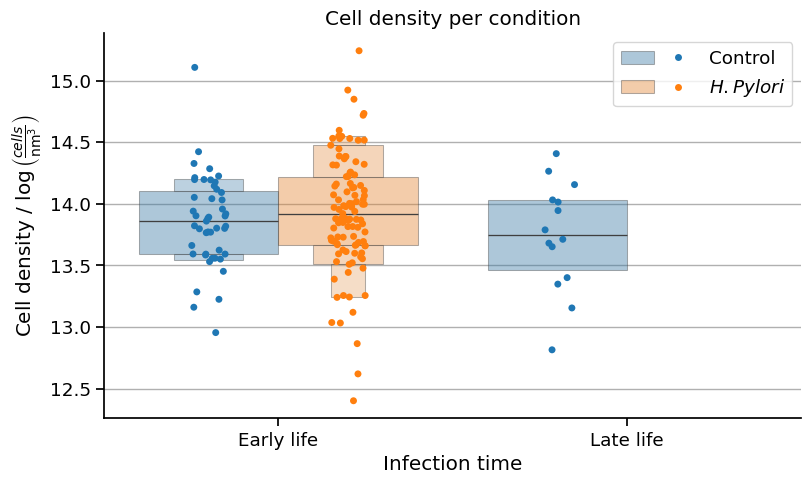

In [63]:

# Create figure and seaborn context
sns.set_context('notebook', font_scale=1.2)
fig, ax1 = plt.subplots(figsize=(9,5))

# Create the plot
sns.boxenplot(y="cells_per_area_log",
hue="Category",
data=Data,
x = 'Infection_time',
box_kws={'alpha': 0.4},
showfliers = False,
ax=ax1
)

sns.stripplot(data=Data,
y="cells_per_area_log",
hue="Category", 
x="Infection_time", 
dodge=True,
ax=ax1)


handles, labels = ax1.get_legend_handles_labels()

ax1.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
          labels=['Control', '$\it{H. Pylori}$'],
          loc='best', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})



# Add grid
ax1.grid(axis='y')
ax1.set_axisbelow(True)
ax1.set_title('Cell density per condition')
ax1.set_ylabel(r'Cell density / $\log\left(\frac{cells}{\mathrm{nm}^3}\right)$')
ax1.set_xlabel('Infection time')


# Remove spine
for s in ["top", "right"]:
    ax1.spines[s].set_visible(False)

# Show the plot
plt.show()

In [68]:
DataTrusted.head(1)

,Name,Experiment,Group,number slices top half,small diameter µm,biggest diameter µm,number cells top half,note for top half,Data trustable,number cells,...,Replication,Slide_number,Organoid_number,Category,Infection_time,Condition,dz,Ellipsoid_surface_area,cells_per_area,cells_per_area_log
0,Early life 1Control1 Ctrl 1,EL1,Control,58.0,396.0,408.0,756.0,good signal,Yes,1254,...,1,1,1,Control,Early life,Early life Control,130.5,1.217802e+06,1.241581e+06,14.031896


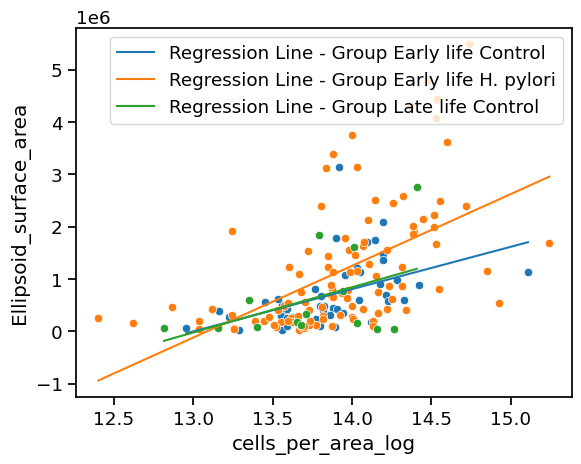

In [80]:
# Fit a linear regression model for each group
for group, group_data in Data.groupby('Condition'):
    model_group = ols(f'Ellipsoid_surface_area ~ cells_per_area_log', data=group_data).fit()
    
    # Create a scatter plot
    sns.scatterplot(x='cells_per_area_log', y='Ellipsoid_surface_area', data=group_data)
    
    # Add the linear regression line
    sns.lineplot(x=group_data['cells_per_area_log'], y=model_group.fittedvalues, label=f'Regression Line - Group {group}')
